# Imports

This section imports all necessary libraries and modules, including PyTorch, NumPy, and a local module bayesipy, which appears to handle Bayesian inference methods. Ensure all dependencies are installed.

In [1]:
# Imports and setup for automatic reloading of modules
%load_ext autoreload
%autoreload 2

# Importing necessary libraries
import numpy as np
import torch
from torch.utils.data import DataLoader
import sys
from time import process_time as timer
import matplotlib.pyplot as plt
from torch import optim
import copy

# Adjusting system path for local imports
sys.path.append("..")
sys.path.append(".")

# Importing custom modules from bayesipy
from bayesipy.utils.datasets import Airline_Dataset
from bayesipy.laplace import TestLaplace

c:\Users\Ludvins\Documents\BayesiPy\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Experimental settings

To ensure reproducibility, a random seed is set. Then, a synthetic dataset is loaded and split into training and test sets, and data loaders are created to handle batched data processing.

In [2]:
# Setting reproducibility
from bayesipy.utils import assert_reproducibility

# Set seed to ensure consistent results across runs
assert_reproducibility(1234)

Load Dataset and desired split.

In [3]:
# Load synthetic dataset and split into train/test sets
dataset = Airline_Dataset()
train_dataset, test_dataset = dataset.train_test_splits()

Number of samples:  600000
Input dimension:  (8,)
Label dimension:  1


Create Data loaders for training and test partitions.

In [4]:
# Define batch size and create DataLoaders for efficient data handling
batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Pretrained MAP solution

In this section, a neural network is initialized and trained as a Maximum a Posteriori (MAP) solution. The network has two hidden layers with Tanh activations and is optimized using the Adam optimizer. After training, the best noise variance is selected by maximizing the log-likelihood on the training data.

In [5]:
from bayesipy.utils.pretrained_models import Airline_MLP

In [6]:
# Initialize neural network for MAP solution with two hidden layers
f = Airline_MLP().to(torch.float64)  # Use double precision

In [7]:
f

Sequential(
  (0): Linear(in_features=8, out_features=200, bias=True)
  (1): Tanh()
  (2): Linear(in_features=200, out_features=200, bias=True)
  (3): Tanh()
  (4): Linear(in_features=200, out_features=200, bias=True)
  (5): Tanh()
  (6): Linear(in_features=200, out_features=1, bias=True)
)

# Laplace Approximation (LLA)

In this part, the Laplace approximation method is applied to approximate the posterior over the model parameters. This approach is computationally efficient and provides Gaussian approximations around a MAP solution.

In [8]:
import torch.nn as nn


class CustomModel(nn.Module):
    def __init__(self, input_dim, secondary_network):
        super(CustomModel, self).__init__()
        self.secondary_network = secondary_network
        self.fc1 = nn.Linear(input_dim, 200)
        self.tanh1 = nn.Tanh()
        self.fc3 = nn.Linear(200, 100)

        for param in self.secondary_network.parameters():
            param.requires_grad = False

        # Define a scalar parameter

    def forward(self, x):
        with torch.no_grad():
            secondary_output = self.secondary_network(x)

        x = self.fc1(x)
        x = self.tanh1(x)
        x = x + secondary_output

        x = self.fc3(x)
        return x

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
# Initialize Laplace Approximation (LLA) model
lla = TestLaplace(
    model=copy.deepcopy(f).to(device).to(torch.float64),  # Copy of MAP-trained model
    model2=CustomModel(8, f[:-1]).to(device).to(torch.float64),
    likelihood="regression",  # Set for regression
    y_mean=dataset.y_mean,  # Mean of training labels
    y_std=dataset.y_std,  # Standard deviation of training labels
)

In [ ]:
min = np.min(train_dataset[:][0], axis=0)
max = np.max(train_dataset[:][0], axis=0)

In [ ]:
class UniformMultidimensionalDataset(torch.utils.data.Dataset):
    def __init__(self, size, low, high):
        self.size = size
        self.low = low
        self.high = high

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        sample = np.random.uniform(self.low, self.high)
        return torch.tensor(sample, dtype=torch.float64), torch.tensor(
            [1], dtype=torch.float64
        )


# Define the size of the dataset
multidimensional_dataset_size = 1000  # You can adjust this size as needed

# Create the dataset
uniform_multidimensional_dataset = UniformMultidimensionalDataset(
    size=multidimensional_dataset_size, low=min, high=max
)

# Create the DataLoader
uniform_loader = DataLoader(
    uniform_multidimensional_dataset, batch_size=batch_size, shuffle=True
)

In [13]:
# Train LLA model to compute posterior scale
losses, losses2 = lla.fit(
    iterations=100000,
    train_loader=train_loader,
    verbose=True,
    context_points_loader=None,
    optimize_hyper_parameters=True,
)

Optimizing Hyper-parameters: 100%|██████████| 100/100 [00:00<00:00, 727.65it/s]


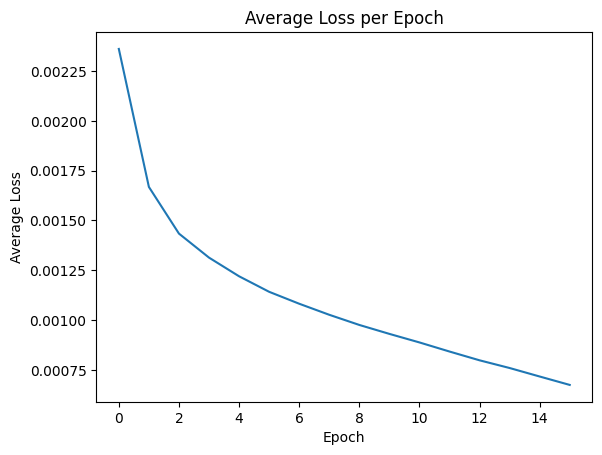

In [ ]:
# Calculate the number of minibatches per epoch
minibatches_per_epoch = int(len(train_dataset) / batch_size)

# Calculate the average loss per epoch
average_losses_per_epoch = [
    np.mean(losses[i * minibatches_per_epoch : (i + 1) * minibatches_per_epoch])
    for i in range(len(losses) // minibatches_per_epoch)
]

# Plot the averaged loss per epoch
plt.plot(average_losses_per_epoch)
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Average Loss per Epoch")
plt.show()

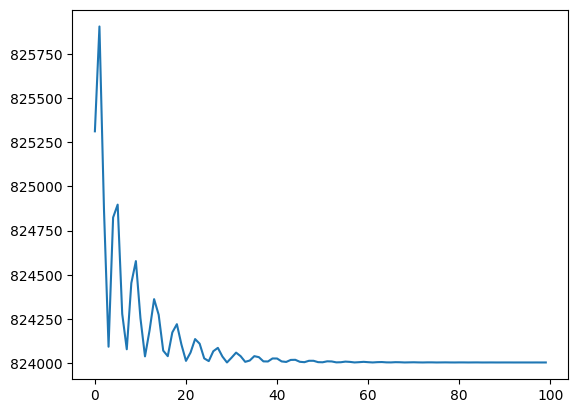

In [15]:
plt.plot(losses2)

In [16]:
from bayesipy.utils.metrics import Regression

In [17]:
# Compute the negative log-likelihood (NLL) over the test set
metrics = Regression()

for data, target in test_loader:
    f_mean, f_var = lla.predict(data.to(device))
    f_var = torch.diag(f_var).reshape(-1, 1)
    metrics.update(target, f_mean, f_var)

d = metrics.get_dict()

In [18]:
d

{'RMSE': 38.90297817593631,
 'NLL': 5.097348529451844,
 'Q-10': 0.12768,
 'Q-20': 0.26164,
 'Q-30': 0.40332,
 'Q-40': 0.53985,
 'Q-50': 0.66371,
 'Q-60': 0.76777,
 'Q-70': 0.84845,
 'Q-80': 0.90377,
 'Q-90': 0.93302,
 'CQM': 0.09492099999999999,
 'CRPS': 18.31621176853736}